In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')

## RANSAC
* random sample consensus
* 데이터셋에서 노이즈를 제거하고 모델을 예측하는 알고리즘
* 특정 임계값을 기준으로 데이터를 무시하고 모델 생성
     + 노이즈를 반영하지 않고 최대 데이터가 일치하는 이상적 모델 생성
     + 즉, 가장 많은 수의 데이터로부터 지지를 받는 모델을 선택한다.
* sklearn에서는 RANSACRegressior라는 객체를 제공
     + 매개변수 :  임계값, 표본수

<img src = 'img/ransac01.png'>
<img src = 'img/ransac02.png'>
<img src = 'img/ransac03.png' width="50%">

## RANSAC 알고리즘
* 가설단계 : 전체데이터에서 N개의 표본을 선택하고, 선택된 표본으로부터 모델을 예측한다.
* 검증단계 : 데이터셋에서 모델과 일치하는 데이터수를 센 후 최대값인 경우 모델의 매개변수를 새롭게 저장함
* RANSAC은 가설과 검증을 N번 반복해서 그 중 최고의 모델을 선정

<img src='img/ransac04.png'>

In [4]:
# 보스턴 집값 데이터셋에서 방수(RM)와 주택평균값(MDEV)에 대해 회귀분석과 RANSAC 분석을 실시하고 결과를 서로 비교
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [5]:
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MDEV'] = boston.target

X = df.RM     # 방수
y = df.MDEV   # 주택가격

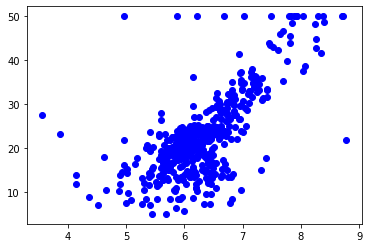

In [11]:
# 단순 선형 회귀 실시
# 산점도로 시각화
plt.plot(X, y, 'bo')

In [18]:
# 단순 선형 회귀 실시해보자
X = np.array(X).reshape(-1,1)
lrclf = LinearRegression()
lrclf.fit(X,y)
pred = lrclf.predict(X)

In [19]:
# 선형모델 계수
a = lrclf.coef_
b = lrclf.intercept_   # 절편

print(a,b)         # 9.1  -34.67

[9.10210898] -34.67062077643857


In [21]:
# 모델 성능 평가
rmse = np.sqrt(mean_squared_error(y,pred))
r2 = r2_score(y,pred)
print(rmse, r2)      # 6.6  0.48

6.603071389222561 0.48352545599133423


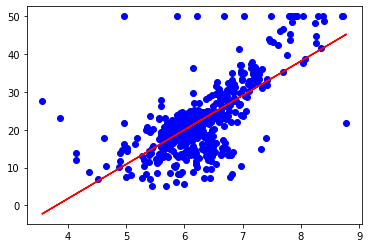

In [22]:
# 회귀선 시각화
z = lrclf.predict(X)
plt.plot(X,y, 'bo')
plt.plot(X,z, 'r-')

In [32]:
# RANSAC 선형회귀 실시
from sklearn.linear_model import RANSACRegressor


# max_trials = 알고리즘 최대 반복횟수
# min_samples = 모델선정에 사용할 무작위 표본의 최소수
# loss : 모델의 성능 평가에 사용할 함수 지정
# absolute_error : 편균절대값 오차
# residual_threshold : 정상치에 포함할 허용오차
lrclf2 = LinearRegression()
ransac = RANSACRegressor(lrclf2, max_trials=500, min_samples=50, loss = 'absolute_error', residual_threshold=5.0, random_state=2111091045)

ransac.fit(X,y)

RANSACRegressor(base_estimator=LinearRegression(), max_trials=500,
                min_samples=50, random_state=2111091045,
                residual_threshold=5.0)

In [29]:
# 선형모델의 계수
a = ransac.estimator_.coef_
b = ransac.estimator_.intercept_
print(a,b)

[10.13609866] -40.2080937417566


In [34]:
# 정상치 inlier 와 이상치 outlier 추출
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

In [43]:
# 회귀선시각화를 위한 변수 생성
z = ransac.predict(X[inlier_mask])

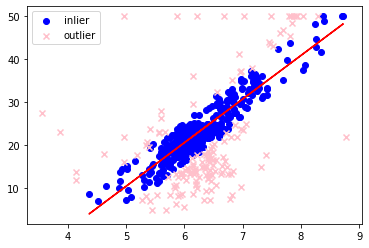

In [45]:
# 정상치와 이상치, 회귀선 시각화
plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o', label = 'inlier')
plt.scatter(X[outlier_mask], y[outlier_mask], c='pink', marker='x', label = 'outlier')

plt.plot(X[inlier_mask], z, 'r-')

plt.legend()

In [48]:
# 모델 성능 평가
rmse = np.sqrt(mean_squared_error(y[inlier_mask],z))
r2 = r2_score(y[inlier_mask],z)
print(rmse, r2)

2.4741094195756936 0.8760762080445963


In [49]:
# 보스턴 집값 데이터셋에서 저소득층비욜 LSTAT와 주택평균가격MDEV에 대해
# 회귀분석과 RASNSAC 분석을 실시하고 결과를 서로 비교해보자

# df = pd.DataFrame(boston.data, columns=boston.feature_names)
# df['LSTAT'] = boston.target

X = df.LSTAT     # 저소득층 비율
y = df.MDEV   # 주택평균가격

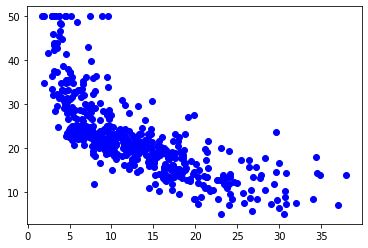

In [50]:
plt.plot(X,y,'bo')

In [53]:
# 선형회귀
X = np.array(X).reshape(-1,1)
lr = LinearRegression()
lr.fit(X, y)
pred= lr.predict(X)

lr.coef_, lr.intercept_

(array([-0.95004935]), 34.5538408793831)

In [54]:
rmse = np.sqrt(mean_squared_error(y, pred))
r2 = r2_score(y, pred)

print(rmse, r2)

6.20346413142642 0.5441462975864797


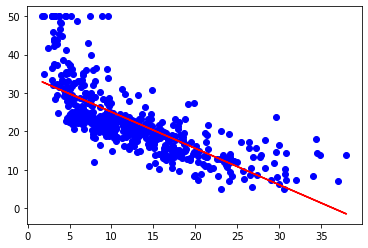

In [55]:
plt.plot(X, y, 'bo')
plt.plot(X,pred,'r-')

In [58]:
# ransac 회귀
lr2 = LinearRegression()
ransac = RANSACRegressor(lr2, max_trials=500, min_samples=50, loss='absolute_error', residual_threshold=5.0, random_state=2111091205)

ransac.fit(X,y)

RANSACRegressor(base_estimator=LinearRegression(), max_trials=500,
                min_samples=50, random_state=2111091205,
                residual_threshold=5.0)

In [59]:
a = ransac.estimator_.coef_
b = ransac.estimator_.intercept_
print(a,b)

[-0.74347328] 29.828872956329434


In [65]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

pred = ransac.predict(X[inlier_mask])

In [63]:
rmse = np.sqrt(mean_squared_error(y[inlier_mask], pred))
r2 = r2_score(y[inlier_mask], pred)
print(rmse, r2)


2.411268834239307 0.7981455201082017


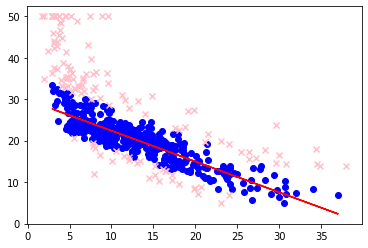

In [64]:
plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o')
plt.scatter(X[outlier_mask], y[outlier_mask], c='pink', marker='x')

plt.plot(X[inlier_mask], pred, 'r-')

## RANSAC 알고리즘 
* 데이터에서 임의의 표본 n 개 선택하여 이름을 inlier로 가정하고
* 나머지 데이터들을 회귀몰델과 비교 - 허용 오차내에 있는 데이터들을 inlier로 포함
* 재구성된 inlier를 이용해 다시 회귀모델을 구하고 오차 측정
* 오차가 허용오차보다 크거나 반복횟수에 도달하면 작업 종료